# Modelo predictivo de compra de clientes

## Información del proyecto

**Rol:** Ingeniera de Inteligencia Artificial  
**Tipo de modelo:** Clasificación binaria (predicción de compra)  
**Objetivo:** Predecir si un cliente realizará una compra (1) o no (0).  

**Requerimiento del cliente:**  
El modelo debe alcanzar una **precisión mínima del 95 %**, entendida como la proporción de
predicciones positivas correctas sobre el total de predicciones positivas realizadas por el modelo.

**Métrica principal de evaluación:**  
Precisión (Precision)

**Herramientas:**  
Google Colab, Python, scikit-learn


**Objetivo:** Predecir si un cliente realizará una compra (1) o no (0).  

**Nota:** Se construye `Purchase = 1 - Churned`.



In [33]:
import os

os.listdir()

['.config', '.ipynb_checkpoints', 'dataset.csv', 'sample_data']

#Imports y configuración visual#

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    precision_recall_curve
)

from sklearn.ensemble import RandomForestClassifier

# Balanceo de clases (solo en train)
from imblearn.over_sampling import SMOTE

# Paleta Modern Fusion
mi_paleta = [
    "#6C5CE7", "#00CEC9", "#FF7675", "#0984E3",
    "#55E6C1", "#FD79A8", "#2D3436", "#DFE6E9"
]
sns.set_palette(mi_paleta)
plt.rcParams["figure.figsize"] = (8, 5)


##Leer CSV + vistazo rápido

Se carga el archivo `dataset.csv` y se verifica la estructura y tipos de dato.

In [35]:
df = pd.read_csv("dataset.csv")

display(df.head())
df.info()
print("\nColumnas:", list(df.columns))


,Churned,Country,Gender,z_Age,z_Login_Frequency,z_Cart_Abandonment_Rate,z_Total_Purchases,z_Product_Reviews_Written,z_Social_Media_Engagement_Score,z_Mobile_App_Usage,z_Credit_Balance,Digital_Score
0,0,3,2,0.468918,0.304115,-0.397966,-0.587640,0.534646,-0.665647,0.168428,0.276392,-0.248610
1,0,7,2,-0.157141,0.432145,-1.190217,0.911237,0.091479,-0.080416,0.448105,0.925216,0.183844
2,0,2,1,0.647791,-0.208006,0.848754,-0.573365,-0.794857,-0.080416,-1.174023,0.310131,-0.627220
3,0,8,1,1.631597,-0.208006,-0.944558,0.268861,0.977814,2.938959,1.309511,0.618971,2.124235
4,0,5,2,-0.246577,2.224568,-2.332532,2.766989,3.636820,2.788767,3.479806,2.937434,3.134286


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Churned                          50000 non-null  int64  
 1   Country                          50000 non-null  int64  
 2   Gender                           50000 non-null  int64  
 3   z_Age                            50000 non-null  float64
 4   z_Login_Frequency                50000 non-null  float64
 5   z_Cart_Abandonment_Rate          50000 non-null  float64
 6   z_Total_Purchases                50000 non-null  float64
 7   z_Product_Reviews_Written        50000 non-null  float64
 8   z_Social_Media_Engagement_Score  50000 non-null  float64
 9   z_Mobile_App_Usage               50000 non-null  float64
 10  z_Credit_Balance                 50000 non-null  float64
 11  Digital_Score                    50000 non-null  float64
dtypes: float64(9), int

#Creación del target

##  Definición de la variable objetivo (Purchase)

El dataset no incluye una columna directa de compra.  
Se infiere mediante `Churned`:

- `Churned = 0` → cliente activo → se asume compra (Purchase = 1)  
- `Churned = 1` → cliente abandonó → se asume no compra (Purchase = 0)

Se crea: `Purchase = 1 - Churned`.


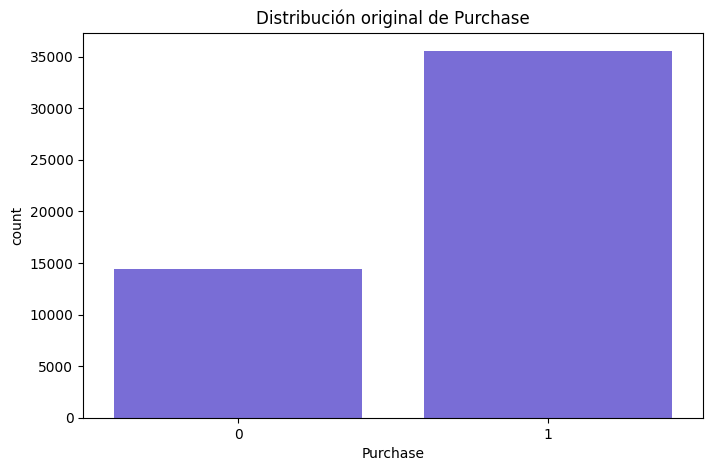

Purchase
1    35550
0    14450
Name: count, dtype: int64

Proporción:
 Purchase
1    0.711
0    0.289
Name: proportion, dtype: float64


In [36]:
# Validación mínima
if "Churned" not in df.columns:
    raise ValueError("No existe la columna 'Churned' en el dataset. Revisa el CSV.")

df["Purchase"] = 1 - df["Churned"]

sns.countplot(x="Purchase", data=df)
plt.title("Distribución original de Purchase")
plt.show()

print(df["Purchase"].value_counts())
print("\nProporción:\n", df["Purchase"].value_counts(normalize=True))



##  Separación de variables predictoras (X) y target (y)

Se eliminan columnas que no deben entrar como input:
- `Purchase` (target)
- `Churned` (origen del target, evita fuga de información)

In [37]:
# X: variables predictoras
X = df.drop(columns=["Purchase", "Churned"])

# y: objetivo
y = df["Purchase"]

# One-Hot Encoding para variables categóricas (por ejemplo: Gender, Country)
X = pd.get_dummies(X, drop_first=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50000, 11)
y shape: (50000,)


##  División Train/Test

Se separa el dataset para evaluar el modelo en datos no vistos:
- 80% entrenamiento
- 20% prueba

Se usa `stratify=y` para mantener la proporción de clases en train y test.


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nDistribución y_train:\n", y_train.value_counts(normalize=True))
print("\nDistribución y_test:\n", y_test.value_counts(normalize=True))


Train: (40000, 11) Test: (10000, 11)

Distribución y_train:
 Purchase
1    0.711
0    0.289
Name: proportion, dtype: float64

Distribución y_test:
 Purchase
1    0.711
0    0.289
Name: proportion, dtype: float64


##  Balanceo de clases con SMOTE (solo entrenamiento)

Se aplica SMOTE únicamente sobre el conjunto de entrenamiento para:
- reducir sesgo hacia la clase mayoritaria
- mejorar capacidad de aprendizaje sobre la clase minoritaria

**Importante:** No se aplica SMOTE al conjunto de test para no contaminar la evaluación.


In [39]:
smote = SMOTE(random_state=42)

X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Antes (train):\n", y_train.value_counts())
print("\nDespués (train balanceado):\n", y_train_bal.value_counts())



Antes (train):
 Purchase
1    28440
0    11560
Name: count, dtype: int64

Después (train balanceado):
 Purchase
1    28440
0    28440
Name: count, dtype: int64


## Entrenamiento del modelo (Random Forest)

Se entrena un RandomForestClassifier como modelo base.

In [40]:
model_base = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

model_base.fit(X_train_bal, y_train_bal)


RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

##  Evaluación inicial (umbral estándar 0.5)

Se calcula:
- Precisión (principal)
- Recall
- F1-score
- Matriz de confusión

Precisión: 0.7968689351791952
Recall: 0.8662447257383966
F1: 0.8301098456769324

Reporte:
               precision    recall  f1-score   support

           0       0.58      0.46      0.51      2890
           1       0.80      0.87      0.83      7110

    accuracy                           0.75     10000
   macro avg       0.69      0.66      0.67     10000
weighted avg       0.73      0.75      0.74     10000



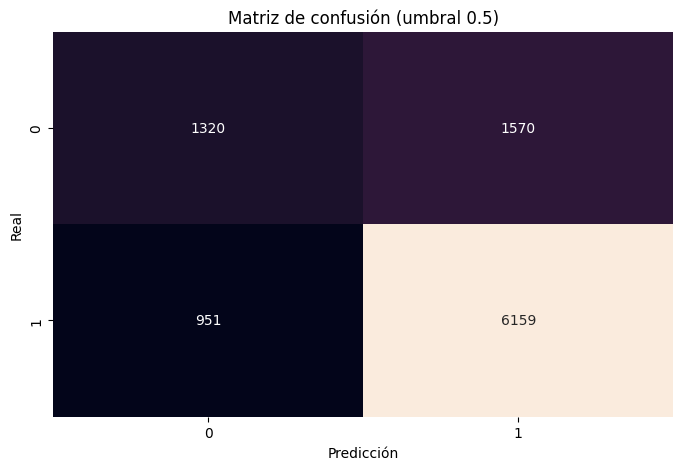

In [41]:
y_pred = model_base.predict(X_test)

prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precisión:", prec)
print("Recall:", rec)
print("F1:", f1)

print("\nReporte:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Matriz de confusión (umbral 0.5)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [42]:
# ============================================================
# Evaluación diagnóstica del modelo sobre datos balanceados
# (SOLO para análisis interno, NO para reporte final)
# ============================================================

# Predicción sobre el conjunto de entrenamiento balanceado
y_train_pred = model_base.predict(X_train)

# Métricas
prec_train = precision_score(y_train, y_train_pred)
rec_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("MÉTRICAS SOBRE TRAIN BALANCEADO (diagnóstico)")
print("Precisión:", round(prec_train, 3))
print("Recall:", round(rec_train, 3))
print("F1-score:", round(f1_train, 3))

print("\nReporte de clasificación (train balanceado):")
print(classification_report(y_train, y_train_pred))



MÉTRICAS SOBRE TRAIN BALANCEADO (diagnóstico)
Precisión: 1.0
Recall: 1.0
F1-score: 1.0

Reporte de clasificación (train balanceado):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11560
           1       1.00      1.00      1.00     28440

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



## Búsqueda automática del umbral para alcanzar Precisión ≥ 0.95

Se busca el menor umbral que cumpla precisión >= 0.95.
Si no existe, se reporta que con el dataset actual no se alcanza.


In [45]:
objetivo_precision = 0.95

y_prob = model_base.predict_proba(X_test)[:, 1]

best_t = None
best_rec = None
best_prec = None

for t in np.linspace(0.5, 0.99, 50):
    y_pred_thr = (y_prob >= t).astype(int)
    p = precision_score(y_test, y_pred_thr, zero_division=0)
    r = recall_score(y_test, y_pred_thr, zero_division=0)

    if p >= objetivo_precision:
        best_t = t
        best_prec = p
        best_rec = r
        break

if best_t is None:
    print("No se alcanzó precisión >= 0.95 con estos datos y este modelo.")
else:
    print(f"Umbral encontrado: {best_t:.3f}")
    print(f"Precisión: {best_prec:.3f} | Recall: {best_rec:.3f}")

Umbral encontrado: 0.940
Precisión: 0.977 | Recall: 0.006


## Importancia de variables (interpretabilidad)

Se calcula el ranking de variables según el Random Forest.
Esto ayuda a entender qué influye más en la predicción.


,0
z_Cart_Abandonment_Rate,0.156980
z_Total_Purchases,0.130043
z_Age,0.115073
z_Product_Reviews_Written,0.106943
Digital_Score,0.095788
z_Login_Frequency,0.091555
z_Mobile_App_Usage,0.086087
z_Credit_Balance,0.084353
z_Social_Media_Engagement_Score,0.077415
Country,0.040263


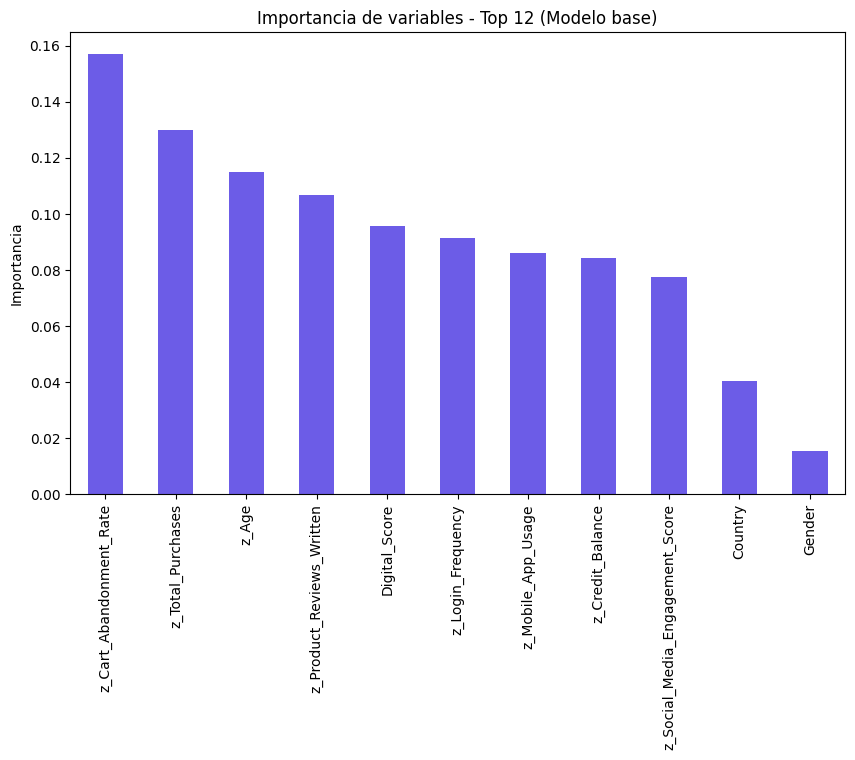

In [46]:
importances = pd.Series(
    model_base.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

display(importances.head(15))

plt.figure(figsize=(10, 6))
importances.head(12).plot(kind="bar", color=mi_paleta[0])
plt.title("Importancia de variables - Top 12 (Modelo base)")
plt.ylabel("Importancia")
plt.show()


##EJERCICIO FINAL — Comparación real vs predicción (10 clientes)

Objetivo:
Comparar el comportamiento real del cliente con la predicción del modelo y evaluar si el modelo acierta.

In [47]:
# ============================================================
# SIMULACIÓN :  (TEST real)
# Umbral fijo = 0.5 (evaluación real)
# ============================================================

np.random.seed(42)
n_clientes = 10

# Seleccionar 10 clientes reales del TEST
X_test_sample = X_test.sample(n_clientes, random_state=42)
y_test_real   = y_test.loc[X_test_sample.index]

# Probabilidades y predicciones
y_test_prob = model_base.predict_proba(X_test_sample)[:, 1]
umbral = 0.5
y_test_pred = (y_test_prob >= umbral).astype(int)

# Tabla comparativa
sim_test = pd.DataFrame({
    "cliente_idx_test": X_test_sample.index,
    "purchase_real": y_test_real.values,
    "prob_compra_modelo": y_test_prob,
    "purchase_predicho": y_test_pred
})

sim_test["resultado"] = np.where(
    sim_test["purchase_real"] == sim_test["purchase_predicho"],
    "ACIERTO",
    "ERROR"
)

print("===== SIMULACIÓN TEST REAL (producción) =====")
print(f"Umbral de decisión: {umbral}")
display(sim_test)


===== SIMULACIÓN TEST REAL (producción) =====
Umbral de decisión: 0.5


,cliente_idx_test,purchase_real,prob_compra_modelo,purchase_predicho,resultado
0,820,1,0.6000,1,ACIERTO
1,37135,1,0.8175,1,ACIERTO
2,9794,1,0.6775,1,ACIERTO
3,10588,1,0.7800,1,ACIERTO
4,38562,1,0.9100,1,ACIERTO
5,24706,1,0.4025,0,ERROR
6,43800,1,0.7475,1,ACIERTO
7,12096,1,0.3500,0,ERROR
8,13442,1,0.5850,1,ACIERTO
9,4849,1,0.8675,1,ACIERTO


⚠️ Evaluación diagnóstica:
Esta simulación se realiza sobre el conjunto de entrenamiento balanceado.
Los resultados NO representan el desempeño real del modelo en producción.


In [48]:
# ============================================================
# SIMULACIÓN 2: (TRAIN balanceado)
# Umbral fijo = 0.5 (diagnóstico)
# ============================================================

np.random.seed(42)
n_clientes = 10

# Seleccionar 10 clientes del TRAIN balanceado
idxs = np.random.choice(len(X_train), size=n_clientes, replace=False)

X_train_sample = X_train.iloc[idxs]
y_train_real   = y_train.iloc[idxs]

# Probabilidades y predicciones
y_train_prob = model_base.predict_proba(X_train_sample)[:, 1]
umbral = 0.5
y_train_pred = (y_train_prob >= umbral).astype(int)

# Tabla comparativa
sim_train = pd.DataFrame({
    "cliente_idx_train": idxs,
    "purchase_real": y_train_real.values,
    "prob_compra_modelo": y_train_prob,
    "purchase_predicho": y_train_pred
})

sim_train["resultado"] = np.where(
    sim_train["purchase_real"] == sim_train["purchase_predicho"],
    "ACIERTO",
    "ERROR"
)

print("===== SIMULACIÓN TRAIN BALANCEADO (diagnóstico) =====")
print(f"Umbral de decisión: {umbral}")
display(sim_train)


===== SIMULACIÓN TRAIN BALANCEADO (diagnóstico) =====
Umbral de decisión: 0.5


,cliente_idx_train,purchase_real,prob_compra_modelo,purchase_predicho,resultado
0,32823,1,0.8075,1,ACIERTO
1,16298,1,0.8450,1,ACIERTO
2,28505,1,0.8450,1,ACIERTO
3,6689,0,0.2075,0,ACIERTO
4,26893,0,0.0375,0,ACIERTO
5,36572,1,0.8725,1,ACIERTO
6,12335,1,0.9300,1,ACIERTO
7,29591,0,0.0100,0,ACIERTO
8,18948,1,0.9625,1,ACIERTO
9,31067,1,0.9300,1,ACIERTO
